# Supervised Fine-tuning (SFT)

El proceso de entrenamiento de un LLM como ChatGPT, Gemini o Deepseek consiste en, a grandes rasgos, tres fases:

- **Pre-entrenamiento**: entrenamiento de predicción del siguiente token (dataset enorme, del orden de toda la web).
- **Supervised Fine-tuning (SFT)**: fine-tuning del modelo preentrenado, usando un conjunto de datos de conversaciones. Esto permite que el modelo adquiera la capacidad de seguir instrucciones y de conversar con el usuario.
- **Reinforcement Learning with Human Feedback (RLHF)**: se busca alinear al modelo con las preferencias humanas (por ejemplo, no groserías).

En este notebook, crearemos un GPT desde cero (https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), y haremos las fases de **pre-entrenamiento** y **SFT**.

## Diferencias entre pre-entrenamiento y SFT

SFT suena similar al pre-entrenamiento, pero hay diferencias clave:

- Plantilla de chat: mientras que en el pre-entrenamiento el modelo predice el siguiente token, en la etapa de SFT el modelo necesita diferenciar quién dijo qué. Por ello, la muestra de entrenamiento debe estar estructurada y contener un delimitador que indique quién es el hablante.

- Función de pérdida enmascarada: el SFT solo calcula la pérdida sobre los tokens de la respuesta del asistente, sin considerar el prompt del usuario. Esto permite que el modelo aprenda si la respuesta del asistente es buena o no.

Por ejemplo, OpenAI usa el siguiente template:

```
<|im_start|>user
Hello, how are you?<|im_end|>
<|im_start|>assistant
I'm fine, thank you!<|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|>
```

El SFT solo calculará la pérdida sobre los tokens de la respuesta del asistente sin considerar el prompt del usuario.

(Por ejemplo, se puede usar CrossEntropyLoss de PyTorch. Según la documentación, si el valor de la etiqueta es –100, la pérdida correspondiente a ese token será ignorada).

## Construcción de un GPT y pre-entrenamiento

La arquitectura que implementaremos es:

<img src="./imgs/1.png" width=500>

Siguiendo de cerca al artículo mencionado.

El objetivo del preentrenamiento es: obtener un modelo que pueda predecir de forma confiable el siguiente token dado los $k$ tokens anteriores de una secuencia.
El resultado final del preentrenamiento es un modelo de deep learning que recibe $k$ tokens y produce una distribución de probabilidad discreta sobre cuál debería ser el token $k+1$. Queremos que esta distribución asigne un valor alto al token correcto y valores bajos a los incorrectos.

<img src="./imgs/2.png" width=500>

Empezaremos con un conjunto de datos grande de texto sin procesar. Este texto puede provenir de libros, blogs, wikis, artículos de investigación y otras fuentes. 

Después de compilar este gran conjunto de datos, lo dividimos en “chunks” de tokens, donde cada chunk contiene una cierta cantidad de tokens (512 en GPT, 1024 en GPT-2, 16 385 en GPT-3). Al tamaño de chunk se le conoce como la “ventana de contexto”.

El modelo tomará esa cantidad de tokens y producirá el siguiente token más probable (token por token, no chunk por chunk).

**Definición de token:** Unidad más pequeña de texto que un modelo puede analizar. Esto es similar a una búsqueda en un diccionario: cada palabra/token tiene un “índice” numérico en la tabla de búsqueda. Este índice es lo que realmente se introduce en la red para ser analizado.

<img src="./imgs/3.png" width=500>

### Datos

**Formato de datos:** Cada ejemplo del conjunto de datos de preentrenamiento es un chunk de tokens. El mismo fragmento se usa como entrada y como salida, pero la salida está desplazada 1 token hacia el “futuro”. La razón de esto tiene que ver con las capacidades de procesamiento paralelo del transformer, algo que explicaremos con más detalle en la sección del transformer.

<img src="./imgs/4.png" width=500>

En primera instancia, usaremos un dataset pequeño que cabe en memoria. Usaremos el dataset [Salesforce wikitext](https://huggingface.co/datasets/EleutherAI/wikitext_document_level) que continene un extracto de artículos de Wikipedia.   

Cargaremos los datasets desde el [hub de datasets de Hugging Face](https://huggingface.co/docs/datasets/en/load_hub). El paquete datasets de Hugging Face proporciona una manera sencilla de cargar, preprocesar y utilizar una variedad de datasets.

In [ ]:
! pip install --upgrade datasets
! pip install tiktoken
! pip install transformers
! pip install torch
! pip install matplotlib

In [1]:
import warnings
import torch
import math
import time
import os
import matplotlib.pyplot as plt
from itertools import cycle
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import _LRScheduler
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from datasets import load_dataset
dataset = load_dataset("EleutherAI/wikitext_document_level", "wikitext-2-raw-v1", split="train")

### Tokenización y chunking del dataset

Un enfoque sencillo para tokenizar y dividir el texto en fragmentos es el siguiente:

- Concatenar todo el texto en un único “bloque” gigante (cadena de texto muy larga).

- Tokenizar todo el bloque en una única lista de tokens (gran arreglo de enteros).

- Dividir los tokens en bloques de tamaño fijo (1024, 2048, más grandes…) (“ventana de contexto”) (múltiples arreglos de enteros)

Este proceso cambiará ligeramente cuando se usen conjuntos de datos demasiado grandes para caber en memoria.


En nuestro caso, usaremos tiktoken. En particular, es la implementación de OpenAI de un tokenizador para BPE (Byte Pair Encoding).

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2") # Get the same tokenizer used for GPT-2


print("Vocabulary size:", tokenizer.n_vocab) # Vocabulary size is how many unique tokens the tokenizer can encode
print("End of text token:", tokenizer.eot_token) # End of text token is used to indicate the end of a text sequence
print("Example tokenization:", tokenizer.encode("Hello world!"))

# Convert entire dataset into a single string
# This dataset is small enough to fit into memory
# For larger datasets, you may need to use more 
# sophisticated methods to process the data.
all_text = ""
all_data = dataset["page"]
for example in all_data:
    all_text += "<page> "+ example + " </page>"

# Tokenize the entire text at once
tokenized_text = tokenizer.encode(all_text)

# We will create a function that generates a dataset of examples
# for the language model.
def get_dataset(num_examples, context_window_length, test_split=0.1):
    input_blocks = [] # List to store input sequences
    target_blocks = [] # List to store target sequences

    # Use a sliding window to create input/target sequences
    for i in range(0, len(tokenized_text), context_window_length + 1):
        block = tokenized_text[i:i+context_window_length+ 1]
        
        # Skip blocks that are too short
        if len(block) < context_window_length + 1:
            continue

        input_seq = block[:-1]  
        target_seq = block[1:]  

        input_blocks.append(input_seq)
        target_blocks.append(target_seq)
        
        # Stop if we have enough examples
        if len(input_blocks) >= num_examples:
            break

    # Convert to tensors for pytorch and move to gpu
    inputs = torch.tensor(input_blocks, dtype=torch.long).to(device)
    targets = torch.tensor(target_blocks, dtype=torch.long).to(device)

    # Calculate train/test split point
    split_idx = int(num_examples * (1 - test_split))

    # Split into train/test
    train_inputs = inputs[:split_idx]
    train_targets = targets[:split_idx]
    test_inputs = inputs[split_idx:]
    test_targets = targets[split_idx:]
    return train_inputs, train_targets, test_inputs, test_targets

# Get a small dataset
i, o, _, _ = get_dataset(2, 4, 0)
print("Input Shape", i.shape)
print("Output Shape", o.shape)
print("Input Example:")
print(i)
print("Output Example:")
print(o)

Vocabulary size: 50257
End of text token: 50256
Example tokenization: [15496, 995, 0]
Input Shape torch.Size([2, 4])
Output Shape torch.Size([2, 4])
Input Example:
tensor([[   27,  7700,    29,   220],
        [  569, 18354,  7496, 17740]], device='cuda:0')
Output Example:
tensor([[ 7700,    29,   220,   796],
        [18354,  7496, 17740,  6711]], device='cuda:0')


### Construcción del LLM

Primero, construiremos un objeto de “configuración” que almacenará nuestros parámetros para la red. Más adelante revisaremos cada parámetro en detalle dentro de la red.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# A simple configuration container
class GPTConfig:
    def __init__(
        self, 
        vocab_size,  # size of the vocabulary, from tokenizer, for gpt2 tokenizer it is 50257
        n_layer,   # number of transformer blocks
        n_head,    # number of attention heads for each transformer block
        n_embd,  # embedding dimension for each token
        seq_len,  # sequence length for the model - e.g. the "context window" 
    
    ):
        self.vocab_size = vocab_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.seq_len = seq_len
     
test_config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=2,  
    n_head=3,
    n_embd=6,
    seq_len=4,
)

Ahora sí, vayamos bloque por bloque.

### Token Embedding Layer

<img src="./imgs/5.png" width=500>

Es esencialmente una tabla de búsqueda que devuelve un “vector de embedding” para un índice entero dado. 

El objetivo de esta capa es convertir tokens en vectores. Estos vectores se tunean a medida que la red se entrena, de modo que su posición en el espacio, en relación con los demás vectores, refleja las relaciones estadísticas entre los tokens.

Después de esta capa, el modelo logra una comprensión semántica de los tokens.

Para nuestro dataset "dummy", la entrada a esta capa será una matriz de tamaño 2×4.
La salida será 2×4×6.

<img src="./imgs/6.png" width=500>

In [5]:
token_embedding = nn.Embedding(test_config.vocab_size, test_config.n_embd).to(device)
test_batch_inputs, _, _, _ = get_dataset(2, test_config.seq_len, 0)
print("Batch shape:", test_batch_inputs.shape, "Batch x Seq Len")
print("After embedding:", token_embedding(test_batch_inputs).shape, "Batch x Seq Len x Embedding Dim")
print("")
print("Before embedding")
print(test_batch_inputs)
print("After embedding")
print(token_embedding(test_batch_inputs))

Batch shape: torch.Size([2, 4]) Batch x Seq Len
After embedding: torch.Size([2, 4, 6]) Batch x Seq Len x Embedding Dim

Before embedding
tensor([[   27,  7700,    29,   220],
        [  569, 18354,  7496, 17740]], device='cuda:0')
After embedding
tensor([[[-0.0850, -0.5393, -0.4814, -0.5201,  0.8528,  1.5614],
         [ 1.7124,  0.9409,  0.5425, -0.2307,  1.0325,  0.6966],
         [ 1.8344, -0.6808,  0.1047,  0.9956,  0.6336,  0.1757],
         [-0.3960, -1.9960, -0.7287,  0.4127,  0.1946, -0.3331]],

        [[ 2.4173, -1.0166,  0.2398, -0.3766, -0.5538,  0.2580],
         [-1.2367, -0.7099, -0.0859, -0.8818, -0.9876,  0.7716],
         [ 1.1070, -0.5770,  0.2477,  2.5843,  0.5314,  1.3516],
         [ 1.0932, -0.0932, -1.0295,  0.9911, -0.2331,  2.5532]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)


(En este momento, la elección de dimensión=6 es arbitraria, y los vectores no tienen sentido sino hasta el entrenamiento de la red).

### Positional Encoding Layer

<img src="./imgs/7.png" width=500>

A cada vector le añadiremos un encoding posicional. ¿Por qué?

Considera: "El planeta es más chico que el otro planeta".

El encoding posicional le permitirá al modelos distinguir entre los dos planetas de la oración.

La fórmula a usar, definida en el paper donde se introduce a los transformers, es la siguiente:

Toma una matriz $PE$ de dimensiones (sequence_length) x (dimensión del embedding $d$). Rellenar de acuerdo a:

$$PE(POS,2i) = sin(\frac{pos}{10000^\frac{2i}{d}})$$
$$PE(POS,2i+1) = cos(\frac{pos}{10000^\frac{2i}{d}})$$

Done $POS$ es la posición del token en la secuencia, e $i$ es el índice de la dimensión de embedding del token.

In [ ]:
def get_position_encoding(seq_len, d, n=10000):
    """
    Computes the positional encoding matrix of shape (seq_len, d).
    
    Args:
        seq_len (int): Length of the sequence.
        d (int): Dimension of the embedding.
        n (float): The base for the exponential term (default 10000 in many Transformer implementations).
    
    Returns:
        torch.Tensor: A tensor of shape (seq_len, d) containing the positional encodings.
    """
    
    P = torch.zeros(seq_len, d).to(device)
    for pos in range(seq_len):
        for i in range(0, d // 2):
            P[pos, 2 * i] = math.sin(pos / (n ** ((2 * i) / d)))
            if i + 1 < d:
                P[pos, 2* i + 1] = math.cos(pos / (n ** ((2 * i) / d)))

    return P.unsqueeze(0)


# Example usage:
position_encoding = get_position_encoding(seq_len=test_config.seq_len, d=test_config.n_embd)
print("Position encoding shape:", position_encoding.shape)

Position encoding shape: torch.Size([1, 4, 6])


Una vez que tenemos esa matriz, la sumamos (por elemento) a los vectores de embedding (vía broadcast). Esto significa que la matriz de encoding posicional se añadirá a cada ejemplo/observación en paralelo.

<img src="./imgs/8.png" width=500>

In [7]:
test_embeddings = token_embedding(test_batch_inputs)
test_embeddings_with_pos = test_embeddings + position_encoding
print("Token embeddings shape:", test_embeddings.shape)
print("Position encodings shape:", position_encoding.shape)
print("Sum of token embeddings and position encodings:",test_embeddings_with_pos.shape)


Token embeddings shape: torch.Size([2, 4, 6])
Position encodings shape: torch.Size([1, 4, 6])
Sum of token embeddings and position encodings: torch.Size([2, 4, 6])


### Masked Multiheaded Self Attention

<img src="./imgs/9.png" width=500>

Llegamos al core del LLM, la parte decoder del transformer. El primer paso del transformer es masked multiheaded self attention, que consiste de tres partes:
- auto-atención (cada token puede influenciar a todos los demás tokens, útil para entender contexto)
- masking
- cabezas múltiples

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Query weights - will transform input embeddings into queries
        self.Wk = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Key weights - will transform input embeddings into keys
        self.Wv = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Value weights - will transform input embeddings into values

    def forward(self, x):
        print("Attention input shape:", x.shape)
        print("")
        print("Query weights shape:", self.Wq.shape)
        print("Key weights shape:", self.Wk.shape)
        print("Value weights shape:", self.Wv.shape)
        queries = x @ self.Wq # Matrix multiplication to transform input embeddings into queries
        keys = x @ self.Wk # Matrix multiplication to transform input embeddings into keys
        values = x @ self.Wv # Matrix multiplication to transform input embeddings into values
        print("")
        print("Queries shape:", queries.shape)
        print("Keys shape:", keys.shape)
        print("Values shape:", values.shape)

        qkt = queries @ keys.transpose(-2, -1) # Calculate QK^T
        qkt_scaled = qkt / math.sqrt(queries.size(-1)) # Scale QK^T by the dimension of the keys
        qkt_softmax = F.softmax(qkt_scaled, dim=-1) # Apply softmax row-wise to get attention weights
        print("")
        print("QK^T shape:", qkt.shape)

        attn_output = qkt_softmax @ values # Multiply softmax(QK^T) by values
        print("")
        print("Attention output shape:", attn_output.shape)
        return attn_output 

attention = SelfAttention(test_config)
test_out = attention(test_embeddings_with_pos)

Attention input shape: torch.Size([2, 4, 6])

Query weights shape: torch.Size([6, 6])
Key weights shape: torch.Size([6, 6])
Value weights shape: torch.Size([6, 6])

Queries shape: torch.Size([2, 4, 6])
Keys shape: torch.Size([2, 4, 6])
Values shape: torch.Size([2, 4, 6])

QK^T shape: torch.Size([2, 4, 4])

Attention output shape: torch.Size([2, 4, 6])


La versión de atención a usar es de hecho la causal, la cual esconde tokens futuros de las capas de auto-atención para evitar que el modelo “vea” información que aún no ha sido generada y así mantener la naturaleza autoregresiva (predicción solo con elementos anteriores) del modelo.

In [9]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Query weights - will transform input embeddings into queries
        self.Wk = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Key weights - will transform input embeddings into keys
        self.Wv = nn.Parameter(torch.randn(config.n_embd, config.n_embd)).to(device) # Value weights - will transform input embeddings into values

    def forward(self, x):
        seq_len = x.shape[1] # Get sequence length (number of tokens / context window length)
        queries = x @ self.Wq # Matrix multiplication to transform input embeddings into queries
        keys = x @ self.Wk    # Matrix multiplication to transform input embeddings into keys
        values = x @ self.Wv  # Matrix multiplication to transform input embeddings into values
        qkt = queries @ keys.transpose(-2, -1)  # Calculate QK^T
        qkt_scaled = qkt / math.sqrt(queries.size(-1))  # Scale QK^T by the dimension of the keys

        # MASKING
        # THIS IS THE ONLY DIFFERENCE, USE -inf FOR UPPER TRIANGLE MASK SO THAT SOFTMAX WILL BE 0
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1)
        causal_mask = causal_mask.masked_fill(causal_mask == 1, float('-inf'))  # Upper triangle masked with -inf 
        qkt_scaled = qkt_scaled + causal_mask # Add the mask to the scaled QK^T
        # END MASKING

        qkt_softmax = F.softmax(qkt_scaled, dim=-1) # Apply softmax row-wise to get attention weights, the -inf values will become 0 here
        attn_output = qkt_softmax @ values # Multiply softmax(QK^T) by values
        return attn_output


attention = CausalSelfAttention(test_config)
test_out = attention(test_embeddings_with_pos)
print(test_out.shape)  # Output should have shape: (batch_size, seq_len, n_embd)

torch.Size([2, 4, 6])


Finalemente, logramos las cabezas múltiples concatenando operaciones CausalAttention en paralelo. Al final de ellas, añadimos una capa para proyectar el output al siguiente tamaño de input.

Tener múltiples capas permite que una se enfoque en estructura gramatical, otra en semántica, y otra en significados de palabra, por ejemplo.

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn_heads = nn.ModuleList([
            CausalSelfAttention(config) for _ in range(config.n_head)
        ])  # Create n_head attention heads
        self.projection = nn.Linear(config.n_embd * config.n_head, config.n_embd).to(device) # Linear layer to project multi-head attention outputs

    def forward(self, x):
        head_outputs = [head(x) for head in self.attn_heads] # Get the output of each attention head
        multihead_output = torch.cat(head_outputs, dim=-1) # Concatenate the outputs
        return self.projection(multihead_output) # Project the concatenated outputs

multihead_attn = MultiHeadAttention(test_config)
test_out = multihead_attn(test_embeddings_with_pos)
print(test_out.shape)  # Output should have shape: (batch_size, seq_len, n_embd)

torch.Size([2, 4, 6])


### Acabando el bloque GPT (normalizations y feed forward)

Acabemos el bloque GPT que le pasaremos al modelo.

<img src="./imgs/10.png" width=500>

**Normalization layers**: Normaliza los valores de la matriz de entrada a lo largo de la dimensión de features (en nuestro caso, la dimensión 2). Se utiliza para estabilizar el entrenamiento y lograr una convergencia más rápida.

**Feed forward layer**: Mientras que la atención captura las relaciones entre tokens, la capa feedforward aplica la misma transformación a cada token en paralelo. Puede implementarse usando capas lineales estándar de PyTorch.

Estamos usando un factor de 4x la dimensión del embedding para el tamaño de la capa lineal, tal como se hizo en el artículo original de Attention Is All You Need.

Utilizamos la función de activación GELU (Gaussian Error Linear Unit), tal como se implementa en el artículo original de GPT.

In [11]:
class GPTBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.mha = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.n_embd).to(device)
        self.ffn = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        ).to(device)
        self.ln2 = nn.LayerNorm(config.n_embd).to(device)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

block = GPTBlock(test_config)
test_out = block(test_embeddings_with_pos)
print(test_out.shape)  # Output should have shape: (batch_size, seq_len, n_embd)

torch.Size([2, 4, 6])


### Encadenando o enchufando todo

In [12]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd).to(device)
        self.position_encoding = get_position_encoding(config.seq_len, config.n_embd)
        self.blocks = nn.Sequential(*[GPTBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd).to(device)
        self.head = nn.Linear(config.n_embd, config.vocab_size).to(device)
    
    def forward(self, x):
        x = self.token_embedding(x) + self.position_encoding
        x = self.blocks(x)
        x = self.ln_f(x)
        return self.head(x)
    
gpt = GPTModel(test_config)
print(test_batch_inputs.shape)
test_out = gpt(test_batch_inputs)
print(test_out.shape)  

torch.Size([2, 4])
torch.Size([2, 4, 50257])


Así, un paso forward completo a través del LLM utiliza un input de tamaño $[batch,tokens]$, y la salida es de tamaño $[batch,tokens,probabilities]$. Para cada token dado en el input, se predicirá una distribución discreta sobre el siguiente token.

<img src="./imgs/11.png" width=500>

### Pre-entrenamiento dummy

La función objetivo a utilizar es:

$$L1(U) = \sum_{i}logP(u_i|u_{i-k}...u_{i-1};\theta)$$

- $U$ es la secuencia de tokens
- $u_i$ es el current token
- $u_{i-k}...u_{i-1}$ son los tokens previos

Notar que tomamos la suma a través de todos los tokens en la secuencia.
Queremos maximizar la probabilidad de predicción del siguiente token, dados $k$ anteriores y los parámetros entrenados $\theta$.

Esto es equivalente a minimizar la función de pérdida cross entropy:

$$H(p, q) = -\sum_{x} p(x) \log q(x)$$

Para probar nuestra arquitectura, entrenaremos el modelo con un dataset (10 ejemplos) y veremos si podemos lograr que el modelo overfitteé.

In [13]:
# Example config:
batch_size = 10
sequence_len = 128
num_steps = 1000
train_inputs, train_targets, _, _ = get_dataset(10, sequence_len, 0)
config = GPTConfig(
    vocab_size=tokenizer.n_vocab,
    n_layer=4,   # fewer layers for a quick demo
    n_head=4,
    n_embd=128,
    seq_len=sequence_len,
)


# Create the GPT model
model = GPTModel(config)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=20, min_lr=5e-6, threshold=1e-4)

# Training loop
i = 1
losses = []

while i < num_steps:
    for j in range(0, len(train_inputs), batch_size):
        x = train_inputs[j:j+batch_size]
        y = train_targets[j:j+batch_size]

        # Forward pass
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        losses.append(loss.item())
        
        optimizer.step()
        optimizer.zero_grad()
    

        loss = loss.item()
        scheduler.step(loss)

   
        # Print the average loss for the epoch
        lr = optimizer.param_groups[0]["lr"]
        print(f"Step {i+1}/{num_steps}, Loss: {loss}, LR: {lr}")

        i += 1


Step 2/1000, Loss: 10.967658996582031, LR: 0.0005
Step 3/1000, Loss: 10.85688591003418, LR: 0.0005
Step 4/1000, Loss: 10.777162551879883, LR: 0.0005
Step 5/1000, Loss: 10.668031692504883, LR: 0.0005
Step 6/1000, Loss: 10.585840225219727, LR: 0.0005
Step 7/1000, Loss: 10.469751358032227, LR: 0.0005
Step 8/1000, Loss: 10.38199234008789, LR: 0.0005
Step 9/1000, Loss: 10.281015396118164, LR: 0.0005
Step 10/1000, Loss: 10.190533638000488, LR: 0.0005
Step 11/1000, Loss: 10.084761619567871, LR: 0.0005
Step 12/1000, Loss: 9.972481727600098, LR: 0.0005
Step 13/1000, Loss: 9.863290786743164, LR: 0.0005
Step 14/1000, Loss: 9.741707801818848, LR: 0.0005
Step 15/1000, Loss: 9.62871265411377, LR: 0.0005
Step 16/1000, Loss: 9.505171775817871, LR: 0.0005
Step 17/1000, Loss: 9.385248184204102, LR: 0.0005
Step 18/1000, Loss: 9.266453742980957, LR: 0.0005
Step 19/1000, Loss: 9.146824836730957, LR: 0.0005
Step 20/1000, Loss: 9.02399730682373, LR: 0.0005
Step 21/1000, Loss: 8.89885425567627, LR: 0.0005
Ste

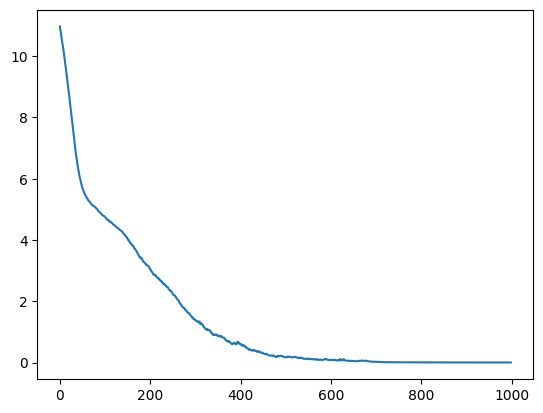

In [14]:
plt.plot(losses)

Ahora, probaremos la memorización del modelo utilizando la función `inference()`.

In [15]:
def inference(prompt, max_new_tokens):
    tokens = tokenizer.encode(prompt)
    for _ in range(max_new_tokens):
        num_tokens = len(tokens)
        tokens_padded = tokens + [tokenizer.eot_token] * (config.seq_len - num_tokens)
        tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device)
        logits = model(tokens_padded)
        predicted_token = torch.argmax(logits[0, num_tokens-1, :]).item()
        tokens.append(predicted_token)
    return tokenizer.decode(tokens)
    
print("Original: ", tokenizer.decode(train_inputs[2].tolist())[:90])
print("Predicted:", inference(" director Takeshi Ozawa . A large team of writers handled the script", max_new_tokens=6))

Original:   director Takeshi Ozawa . A large team of writers handled the script . The game 's opening
Predicted:  director Takeshi Ozawa . A large team of writers handled the script . The game 's opening


### Pre-entrenamiento real

Utilizaremos ahore el *Huggingface Streaming Dataset*.

In [ ]:
# Load dataset in streaming mode
ds = load_dataset("abisee/cnn_dailymail", "3.0.0", split="train")
hf_tokenizer = AutoTokenizer.from_pretrained("gpt2")

def check_dataset_exists():
    try:
        # Attempt to load the dataset with reuse_cache_if_exists mode
        load_dataset("parquet", data_files="cnn_dailymail_train.parquet", split="train")
        load_dataset("parquet", data_files="cnn_dailymail_test.parquet", split="train")
        return True
    except FileNotFoundError:
        return False
    
if not check_dataset_exists():
    print("Tokenized dataset does not exist locally... Generating and saving to disk.")

    def tokenize_and_chunk(dataset, tokenizer, chunk_size=512, train_rows=100_000, test_rows=500):
        """
        Tokenizes and chunks the dataset into fixed-length 512-token segments.
        The 'target' sequence is shifted left by 1 token.
        Stops after generating `train_rows + test_rows` tokenized chunks.
        """
        buffer = []  # Rolling buffer for tokens
        row_count = 0

        for example in dataset:
            tokens = tokenizer(example["article"], truncation=False, padding=False)['input_ids']
            buffer.extend(tokens)

            # Yield full chunks until we reach train_rows + test_rows
            while len(buffer) >= chunk_size + 1:  # +1 to ensure we can shift target
                if row_count >= (train_rows + test_rows):
                    return  # Stop yielding once enough rows are reached

                # Create input-target pairs
                input_chunk = buffer[:chunk_size]         # First 512 tokens
                target_chunk = buffer[1:chunk_size + 1]  # Shifted by 1 token
                
                # Assign to train or test split
                split = "train" if row_count < train_rows else "test"

                yield {
                    "split": split,
                    "input": input_chunk, 
                    "target": target_chunk
                }
                
                buffer = buffer[chunk_size:]  # Remove used tokens
                row_count += 1

    # Set the max number of rows for training and testing
    TRAIN_ROWS = 1400000  # Adjust as needed
    TEST_ROWS = 500   # Adjust as needed
    CHUNK_SIZE = 128

    # Convert generator to a Hugging Face Dataset
    tokenized_ds = Dataset.from_generator(lambda: tokenize_and_chunk(ds, hf_tokenizer,chunk_size=CHUNK_SIZE, train_rows=TRAIN_ROWS, test_rows=TEST_ROWS))

    # Split the dataset into `train` and `test`
    dataset_splits = tokenized_ds.train_test_split(test_size=TEST_ROWS / (TRAIN_ROWS + TEST_ROWS), seed=42)

    # Save to disk
    dataset_splits["train"].to_parquet("cnn_dailymail_train.parquet")
    dataset_splits["test"].to_parquet("cnn_dailymail_test.parquet")

    print(f"✅ Saved {TRAIN_ROWS} train rows and {TEST_ROWS} test rows.")
else:
    print("Tokenized dataset already exists locally.")

Utilizamos parquet para el manejo de datasets grandes, así el modelo no tendrá que tener el dataset entero en memoria.

In [17]:
# Example config:
batch_size = 64
sequence_len = 128
num_steps = 150000
accumulation_steps = 100


# Reload the train and test datasets
train_ds = load_dataset("parquet", data_files="cnn_dailymail_train.parquet", split="train")
test_ds = load_dataset("parquet", data_files="cnn_dailymail_test.parquet", split="train")

# Convert dataset to PyTorch format
train_ds.set_format("torch", columns=["input", "target"])
test_ds.set_format("torch", columns=["input", "target"])

# Create DataLoaders for training and testing
train_dataloader = cycle(DataLoader(train_ds, batch_size=batch_size, shuffle=False))
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

config = GPTConfig(
    vocab_size=hf_tokenizer.vocab_size,
    n_layer=8,   # fewer layers for a quick demo
    n_head=8,
    n_embd=128,
    seq_len=sequence_len,
)

# Create the GPT model
model = GPTModel(config)

use_existing_model = os.path.exists("./pretrain_final.pth")
# Check if pre-trained model exists
if use_existing_model:
    model = torch.load("./pretrain_final.pth")
    print("Loaded pre-trained model from ./pretrain_final.pth, skipping training loop.")

else:
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


    # Define Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.3, patience=10, min_lr=5e-6, threshold=1e-4)


    # Training loop
    losses = []
    test_losses = []
    accumulator = 0
    accumulator_loss = 0
    start_time = time.time()
    for i in range(num_steps):
        model.train()
        example = next(train_dataloader)
        train_input = example["input"].to(device)
        train_target = example["target"].to(device)

        logits = model(train_input)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), train_target.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

        accumulator += 1
        accumulator_loss += loss.item()

        
        if accumulator >= accumulation_steps:
            losses.append(accumulator_loss / accumulation_steps)
            accumulator = 0
            accumulator_loss = 0
            model.eval()
            test_loss = 0
            test_accumulator = 0
            with torch.no_grad():
                for test_example in test_dataloader:
                    test_input = test_example["input"].to(device)
                    test_target = test_example["target"].to(device)
                    test_logits = model(test_input)
                    test_loss += F.cross_entropy(test_logits.view(-1, test_logits.size(-1)), test_target.view(-1)).item()
                    test_accumulator += 1
                test_losses.append(test_loss / test_accumulator)
                elapsed_time = time.time() - start_time
                print(f"Step {i+1}/{num_steps}, Loss: {losses[-1]}, Test Loss: {test_losses[-1]}, LR: {optimizer.param_groups[0]['lr']}, Elapsed Time: {elapsed_time:.2f} seconds")
                test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
                scheduler.step(test_losses[-1])

   
        if (i+1) % 50000 == 0:
            # Save the model checkpoint
            print(f"Saving model checkpoint at step {i+1}")
            torch.save(model, f"./model_checkpoint_{i}.pt")
        

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step 100/150000, Loss: 8.435567221641541, Test Loss: 7.553930699825287, LR: 0.0005, Elapsed Time: 10.30 seconds
Step 200/150000, Loss: 7.54877815246582, Test Loss: 7.525772750377655, LR: 0.0005, Elapsed Time: 20.54 seconds
Step 300/150000, Loss: 7.526817994117737, Test Loss: 7.517217397689819, LR: 0.0005, Elapsed Time: 30.79 seconds
Step 400/150000, Loss: 7.927651295661926, Test Loss: 7.508810877799988, LR: 0.0005, Elapsed Time: 41.07 seconds
Step 500/150000, Loss: 7.511321864128113, Test Loss: 7.487947523593903, LR: 0.0005, Elapsed Time: 51.26 seconds
Step 600/150000, Loss: 7.476530842781067, Test Loss: 7.447194814682007, LR: 0.0005, Elapsed Time: 61.53 seconds
Step 700/150000, Loss: 7.439467644691467, Test Loss: 7.41978245973587, LR: 0.0005, Elapsed Time: 71.85 seconds
Step 800/150000, Loss: 7.416441283226013, Test Loss: 7.398671627044678, LR: 0.0005, Elapsed Time: 82.34 seconds
Step 900/150000, Loss: 7.397604651451111, Test Loss: 7.382740795612335, LR: 0.0005, Elapsed Time: 92.67 se

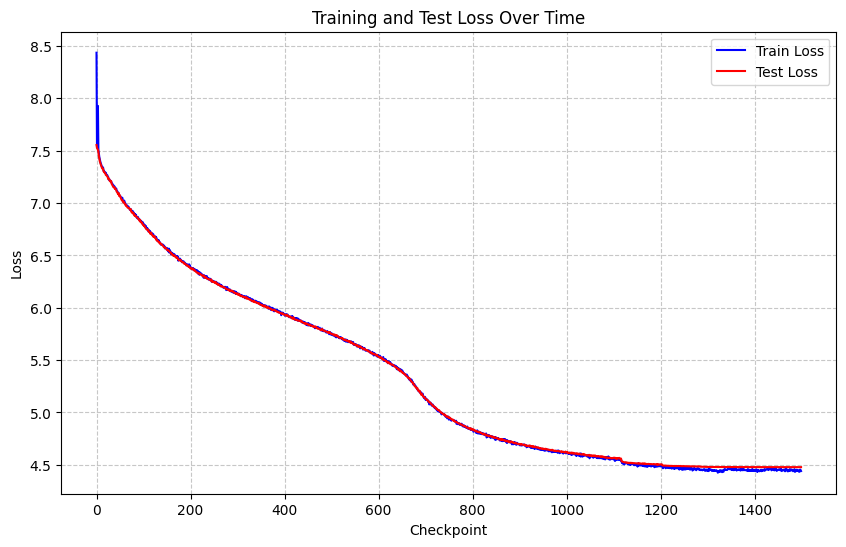

In [18]:
if use_existing_model:
    print("Existing model used, no loss curves shown.")
    plt.imshow(plt.imread("./loss_curve.png"))
else:
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='red')
    plt.xlabel('Checkpoint')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [19]:
if not use_existing_model:
    torch.save(model, f"./pretrain_final.pth")

### Inferencia del modelo pre-entrenado

Podemos ver que el modelo es capaz de producir inglés legible y que la mayoría de las palabras tienen sentido. Sin embargo, sus limitaciones de tamaño hacen que no sea tan sólido como los modelos más grandes. Aun así, es lo suficientemente bueno como para ver unos *sparks* de comprensión de lenguaje.

In [20]:
def inference(prompt,torch_model, max_new_tokens):
    torch_model.eval()
    with torch.no_grad():
        tokens = hf_tokenizer.encode(prompt)
        for _ in range(max_new_tokens):
            num_tokens = len(tokens)
            tokens_padded = tokens + [hf_tokenizer.eos_token_id] * (config.seq_len - num_tokens)
            tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device)
            logits = torch_model(tokens_padded)
            probabilities = torch.softmax(logits[0, num_tokens-1, :], dim=-1)
            predicted_token = torch.multinomial(probabilities, 1).item()
            tokens.append(predicted_token)
        return hf_tokenizer.decode(tokens)

In [21]:
print("Predicted:", inference("The president signed a bill to pass", model, max_new_tokens=20))
print("Predicted:", inference("There was a large division in", model, max_new_tokens=20))
print("Predicted:", inference("Reports are showing that", model, max_new_tokens=20))

2025-02-15 09:21:39.354292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 09:21:39.354348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 09:21:39.355365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 09:21:39.361722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-15 09:21:40.186448: W tensorflow/compiler/tf2

Predicted: The president signed a bill to pass the bailout policy, and that's not necessarily in the Democratic Republic." Obama seems to have his closest
Predicted: There was a large division in some kind disguised battles to film Chinese. I voted myself again, but I think the Internet's terms
Predicted: Reports are showing that their advances in optimal traffic culture where each athlete's shift is allowable using drones, an 8-strong


## Supervised Fine-tuning (SFT)

Para hacer el modelo más usable, tomamos el modelo preentrenado y lo hacemos pasar por un proceso llamado **ajuste fino supervisado**. Este proceso consiste en usar conjuntos de datos de texto supervisados y de alta calidad para lograr que el modelo responda como queremos.

Para esto podemos usar el conjunto de datos [Fact Q&A](https://huggingface.co/datasets/rubenroy/GammaCorpus-Fact-QA-450k?library=datasets) de Hugging Face. Este conjunto de datos consiste en ejemplos de preguntas y respuestas que son cortos, lo cual es bueno para nuestro caso de uso ya que tenemos una ventana de contexto pequeña de 128 tokens.

El ajuste fino supervisado es donde podemos introducir “etiquetas” y otros tipos de tokens de texto que pueden ayudar al modelo a entender diferentes roles en el texto. Para nuestro conjunto de datos, tendremos una etiqueta de “question” y una de “answer”. Agregaremos todo esto cuando creemos nuestro conjunto de datos y también durante la inferencia cuando un usuario envíe una consulta. También añadimos tokens eos para finalizar o rellenar los ejemplos que no ocupen toda la ventana de contexto.

Después de este *fine-tuning*, tendremos un LLM al que se le pueda hacer una pregunta y obtener una respuesta (una manera usual de interacción con los LLMs populares).

In [22]:
# Load dataset in streaming mode
sft_ds = load_dataset("rubenroy/GammaCorpus-Fact-QA-450k", split="train", streaming=True)

def check_sft_dataset_exists():
    try:
        # Attempt to load the dataset with reuse_cache_if_exists mode
        load_dataset("parquet", data_files="fact_qa_train.parquet", split="train")
        load_dataset("parquet", data_files="fact_qa_test.parquet", split="train")
        return True
    except FileNotFoundError:
        return False
    
if not check_sft_dataset_exists():
    print("Tokenized supervised fine tuning dataset does not exist locally... Generating and saving to disk.")

    def tokenize_and_chunk(dataset, tokenizer, chunk_size=512, rows=1000):
        """
        Tokenizes and chunks the dataset into fixed-length 512-token segments.
        The 'target' sequence is shifted left by 1 token.
        Stops after generating `train_rows + test_rows` tokenized chunks.
        """
        row_count = 0

        for example in dataset:
            question_plus_answer = "<Question>" + example["question"] + "</Question>" + "<Answer>" + example["answer"] + "</Answer>"
            input_tokens = tokenizer(question_plus_answer, truncation=False, padding=False)['input_ids']

            if row_count >= rows:
                return

            if len(input_tokens) >= chunk_size:
                continue
            else:
                input_tokens = input_tokens +[tokenizer.eos_token_id] * (chunk_size - len(input_tokens))
            
            target_tokens = input_tokens[1:] + [tokenizer.eos_token_id]  # Shifted by 1 token

            yield {
                "input": input_tokens, 
                "target": target_tokens
            }
            
            row_count += 1

    # Set the max number of rows for training and testing
    TRAIN_ROWS = 440000  # Adjust as needed
    TEST_ROWS = 500   # Adjust as needed
    CHUNK_SIZE = 128

    # Convert generator to a Hugging Face Dataset
    tokenized_sft_dataset = Dataset.from_generator(lambda: tokenize_and_chunk(sft_ds, hf_tokenizer,chunk_size=CHUNK_SIZE, rows=TRAIN_ROWS + TEST_ROWS))

    # Split the dataset into `train` and `test`
    sft_dataset_splits = tokenized_sft_dataset.train_test_split(train_size=TRAIN_ROWS, test_size=TEST_ROWS, seed=42)

    # Save to disk
    sft_dataset_splits["train"].to_parquet("fact_qa_train.parquet")
    sft_dataset_splits["test"].to_parquet("fact_qa_test.parquet")

    print(f"✅ Saved {TRAIN_ROWS} train rows and {TEST_ROWS} test rows for supervised fine tuning.")
else:
    print("SFT Tokenized dataset already exists locally.")

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Tokenized supervised fine tuning dataset does not exist locally... Generating and saving to disk.


Generating train split: 0 examples [00:00, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/440 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

✅ Saved 440000 train rows and 500 test rows for supervised fine tuning.


### Fine Tuning Training Loop

In [23]:
# Example config:
batch_size = 64
sequence_len = 128
num_steps = 50000
accumulation_steps = 100

# Reload the train and test datasets
train_ds = load_dataset("parquet", data_files="fact_qa_train.parquet", split="train")
test_ds = load_dataset("parquet", data_files="fact_qa_test.parquet", split="train")

# Convert dataset to PyTorch format
train_ds.set_format("torch", columns=["input", "target"])
test_ds.set_format("torch", columns=["input", "target"])

# Create DataLoaders for training and testing
train_dataloader = cycle(DataLoader(train_ds, batch_size=batch_size, shuffle=False))
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


use_existing_model = os.path.exists("./sft_final.pth")
# Check if pre-trained model exists
if use_existing_model:
    model = torch.load("./sft_final.pth")
    print("Loaded fine tuned model from ./sft_final.pth, skipping training loop.")

else:
    # For SFT we start with the pretrained model
    model = torch.load("./pretrain_final.pth")
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


    # Scheduler with dynamic step size
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=10, min_lr=5e-6, threshold=1e-4)


    # Training loop
    losses = []
    test_losses = []
    accumulator = 0
    accumulator_loss = 0
    for i in range(num_steps):
        model.train()
        example = next(train_dataloader)
        train_input = example["input"].to(device)
        train_target = example["target"].to(device)
        logits = model(train_input)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), train_target.view(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

        accumulator += 1
        accumulator_loss += loss.item()

        

        if accumulator >= accumulation_steps:
            losses.append(accumulator_loss / accumulation_steps)
            accumulator = 0
            accumulator_loss = 0
            model.eval()
            test_loss = 0
            test_accumulator = 0
            with torch.no_grad():
                for test_example in test_dataloader:
                    test_input = test_example["input"].to(device)
                    test_target = test_example["target"].to(device)
                    test_logits = model(test_input)
                    test_loss += F.cross_entropy(test_logits.view(-1, test_logits.size(-1)), test_target.view(-1)).item()
                    test_accumulator += 1
                test_losses.append(test_loss / test_accumulator)
                print(f"Step {i+1}/{num_steps}, Loss: {losses[-1]}, Test Loss: {test_losses[-1]}")
                test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
                scheduler.step(test_losses[-1])

        if i+1 % 50000 == 0:
            torch.save(model.state_dict(), f"./sft_model_checkpoint_{i}.pt")
        

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step 100/50000, Loss: 1.9918309170007706, Test Loss: 0.7444852367043495
Step 200/50000, Loss: 0.7175035107135773, Test Loss: 0.7121347188949585
Step 300/50000, Loss: 0.7018899911642075, Test Loss: 0.6949615925550461
Step 400/50000, Loss: 0.6908353179693222, Test Loss: 0.6887291222810745
Step 500/50000, Loss: 0.6768182325363159, Test Loss: 0.6792757734656334
Step 600/50000, Loss: 0.674177388548851, Test Loss: 0.6729135736823082
Step 700/50000, Loss: 0.6727178591489792, Test Loss: 0.665991447865963
Step 800/50000, Loss: 0.6694402080774308, Test Loss: 0.6644480600953102
Step 900/50000, Loss: 0.6582337802648545, Test Loss: 0.6569188311696053
Step 1000/50000, Loss: 0.6548500311374664, Test Loss: 0.6566447466611862
Step 1100/50000, Loss: 0.6548229521512985, Test Loss: 0.651200458407402
Step 1200/50000, Loss: 0.6486632919311524, Test Loss: 0.6475077718496323
Step 1300/50000, Loss: 0.6484963500499725, Test Loss: 0.6474942564964294
Step 1400/50000, Loss: 0.6471871453523635, Test Loss: 0.6445949

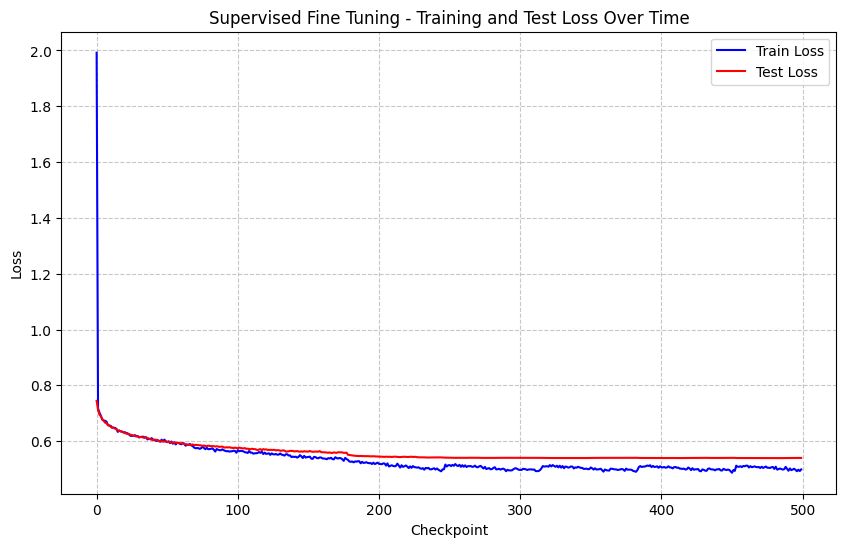

In [24]:
if use_existing_model:
    print("Existing model used, no loss curves shown.")
    plt.imshow(plt.imread("./sft_loss_curve.png"))
else:
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='red')
    plt.xlabel('Checkpoint')
    plt.ylabel('Loss')
    plt.title('Supervised Fine Tuning - Training and Test Loss Over Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [25]:
if not use_existing_model:
    torch.save(model, f"./sft_final.pth")

### Inferencia final

Ahora sí, podemos realizar una forma más natural de inferencia. En lugar de formatear todos nuestros prompts como predicción del siguiente token, podemos usar un formato de preguntas y respuestas o Q&A.

Estamos usando un modelo muy pequeño y un conjunto de datos muy reducido en comparación con los LLM modernos, por lo que nuestro modelo no va a desempeñarse muy bien en la práctica.

Sin embargo, se generan respuestas que al menos están relacionadas con el prompt y formateadas de manera correcta.

A medida que escalemos el modelo, los datos, etc., las respuestas se volverán más reales, precisas y contextualmente adecuadas.

In [26]:
def sft_inference(prompt,torch_model, max_new_tokens):
    torch_model.eval()
    prompt = "<Question>" + prompt + "</Question>" + "<Answer>" # Wrap the prompt in <Question> and start inference with <Answer>
    with torch.no_grad(): 
        tokens = hf_tokenizer.encode(prompt) # Tokenize the prompt
        for _ in range(max_new_tokens):
            if tokens[-1] == hf_tokenizer.eos_token_id: # Stop if we reach the end of the sequence
                break
            num_tokens = len(tokens) # 
            tokens_padded = tokens + [hf_tokenizer.eos_token_id] * (config.seq_len - num_tokens) # pad the sequence with eos token
            tokens_padded = torch.tensor(tokens_padded).unsqueeze(0).to(device) 
            logits = torch_model(tokens_padded) # Forward pass through the model
            probabilities = torch.softmax(logits[0, num_tokens-1, :], dim=-1) # Get the probabilities of the last token
            predicted_token = torch.argmax(probabilities).item() # Greedy decoding, change to sampling for more diversity
            tokens.append(predicted_token)
        
        # Strip the text to between the <Answer></Answer> tags
        full_answer = hf_tokenizer.decode(tokens)
        answer_start = full_answer.find("<Answer>") + len("<Answer>")
        answer_end = full_answer.find("</Answer>")
        return full_answer[answer_start:answer_end]

In [ ]:
print("Predicted:", sft_inference("Who is the most powerful leader in the west?", model, max_new_tokens=20))
print("Predicted:", sft_inference("What color is the sun?", model, max_new_tokens=20))
print("Predicted:", sft_inference("What color is the ocean", model, max_new_tokens=20))
print("Predicted:", sft_inference("How many planets are in the solar system", model, max_new_tokens=20))
print("Predicted:", sft_inference("What three countries are in north america?", model, max_new_tokens=20))
print("Predicted:", sft_inference("How many eyes do humans have?", model, max_new_tokens=20))


Predicted: The President of the Republic of the Republic of the Congo
Predicted: Yellow
Predicted: Red
Predicted: Two
Predicted: United States and Canada
Predicted: Two-four-four-four-four-four-four-four-four-four
